In [3]:
# Main parameters

# check if it's a Colab notebook
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

MODEL_TYPE = 'TDNN' # 'Heuristic', 'Scattershot', 'TDNN'

nn_config_name = 'config-0426-ModGaussian_no_reconstruction.yaml'
nn_checkpoint_number = 24
nn_checkpoint_name = f'{nn_config_name.split(".")[0]}_{nn_checkpoint_number}.pth'


data_source = 'synthetic'
results_file_name = f'for_plot_{nn_config_name.split(".")[0]}_{MODEL_TYPE}_{data_source}'

compare_abs = True

In [4]:
# Secondary parameters


git_branch = 'origina_pipeline'


import os
if IN_COLAB:
    from google.colab import runtime, userdata
    !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
    import colab_github
    colab_github.github_auth(persistent_key=True)
    # https://github.com/tsunrise/colab-github/tree/main

    ! rm -rf submovement_detector
    ! git clone "REMOVED_FOR_ANONYMITY"
    %cd submovement_detector
    !git checkout {git_branch}
    # %cd ..

    import sys
    sys.path.append('/content/submovement_detector')

    !pip install torchviz
    !pip install fastkde

    root_dir = f'/content/drive/MyDrive/submov_nn'
    wandb_key = userdata.get('WANDB_KEY')
    code_dir = '/content/submovement_detector'
else:
    root_dir = f'./submov_nn'
    wandb_key = os.getenv('WANDB_KEY')
    code_dir = '.'

#CONFIG_PATH = f'{root_dir}/config/config-0414_amplitude_by_duration.yaml'
CONFIG_PATH = f'{root_dir}/config/{nn_config_name}'
USE_WANDB = False
VIZUALIZE_BAD_AMPLITUDES = False

datasets_dir = f'{root_dir}/data/'
dataset2path = {
     # 'crank1d':
    'steering': os.path.join(datasets_dir, 'steering_tangential_velocity_data.csv'),
    'crank': os.path.join(datasets_dir, 'crank_tangential_velocity_data.csv'),
    'Fitts': os.path.join(datasets_dir, 'Fitts_tangential_velocity_data.csv'),
    'whacamole': os.path.join(datasets_dir, 'whacamole_tangential_velocity_data.csv'),
    'object_moving': os.path.join(datasets_dir, 'object_moving_tangential_velocity_data.csv'),
    'pointing': os.path.join(datasets_dir, 'pointing_tangential_velocity_data.csv'),
    'tablet_writing': os.path.join(datasets_dir, 'tablet_writing_tangential_velocity_data.csv'),
}

dataset_names = dataset2path.keys()
# train_noise_condition = (10, 50)

noise_conditions = [float('inf'), 20, 10] # will be used since now
# noise_conditions = [float('inf')] + list(range(50, -1, -10))
# refractory_conditions = [(0.2, 1.2), (0.5, 1.5), (1, 2)]


# model_file = 'config-0414_amplitude_by_duration_24.pth'
model_file = nn_checkpoint_name
proportions = [0.13] * 8

In [5]:
# Imports

import os
import math
import time
import random
import copy
from collections import defaultdict

from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter  # TensorBoard writer

import wandb

from data import SyntheticDataset, OrganicDataset, CombinedSyntheticDataset
from models import TDNNDetector, STEContinuousReconstructor, STEBinarizer
from utils import onset_prediction_metrics_on_masks, Config, evaluate_on_organic_data, evaluate_on_synthetic_data, \
    calculate_reconstruction_metrics, calculate_supervised_metrics, \
    evaluate_organic_trials_for_bootstrap, hierarchical_bootstrap_metrics

from sklearn.metrics import r2_score, mean_absolute_error




def log(message, file):
    with open(file, 'a') as f:
        f.write(message + '\n')
    print(message)



In [6]:
# First config and wandb

config = Config(CONFIG_PATH, root_dir=root_dir)

if USE_WANDB:
    wandb.login(key=wandb_key)
    wandb.init(project='submovement_detector', name=config.experiment_name, config=config.to_dict() , save_code=True) #, settings=wandb.Settings(code_dir='.'))

    wandb.run.log_code(code_dir, include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))


In [7]:
# Alternative methods

from movement_decompose import decompose_pytorch_style
from alternative_detectors import heuristic_pytorch_style

if MODEL_TYPE == 'Scattershot':

    model = lambda x: decompose_pytorch_style(x,
                                            mask_true=None,
                                            window_size=120, # 120, 180, 240  - 120 - 1
                                            step_size=60,
                                            max_submovements_per_window=24, # maybe overkill
                                            displacement_rng=(-30., 30.),
                                            duration_rng=(5, 60),
                                            n_iter=10,
                                            scale_error=True,
                                            optimizer='L-BFGS-B',
                                            options=None,
                                            limit_clutters=False,
                                            error_threshold=0.15, # 0, 0.025, 0.05, 0.075 - 0.25, 0.5, 0.75 - 3
                                            exact_number_of_submovements=False,
                                            patience=1, # 0, 1, 2, 3, 4 - 1, 2, 3 - 3
                                            debug_level=0, # 0 - no debug, 1 - only the final message, 2 -  within current function, 3 - full debug
    )
elif MODEL_TYPE == 'Heuristic':
    model = lambda x: heuristic_pytorch_style(x, theta=0.0375, smooth_method='gaussian', sigma=2.5)
    # params 1: smooth_method='gaussian', theta=0.05, sigma=2.5 - 0.8519, 0.5613, 0.4782
    # params 2: smooth_method='cheby', theta=0.0625, cutoff=3.75, order=3, ripple=0.05 - 0.9106, 0.5721, 0.5210
    # grid search with theta 0:0.25:0.125 - 21 steps, sigma 0:4:0.25 - 17 steps, cutoff 2:15:0.25 - 53 steps, order 1:7:1 - 7 steps, ripple 0.025:0.2:0.025 - 8 steps
    # first search then 21*17 ~ 350 evals, second search ~ 21*53*7*8 ~ 56000

    # how to call a grid and then Newton?


In [ ]:
# Load the model, load the dataset


# %%
# Instantiate the config
if __name__ == '__main__':

    config = Config(CONFIG_PATH, root_dir=root_dir)

    if MODEL_TYPE != 'TDNN':
        config.device = torch.device('cpu')

    # config.experiment_name = CONFIG_PATH.split('/')[-1].replace('.yaml', '') + '_for_test'
    config.start_with_weights = model_file
    config.proportions = proportions

    # Some basic dataset parameters, can be changed further down
    config.total_duration_distribution = 1000
    config.batch_size = 512 # does it affect the running?
    config.num_samples = 1
    config.refractory_distribution = [0, 1.5] # this is going to be used for the synthetic dataset

    # os.makedirs(os.path.dirname(config.log_file), exist_ok=True)
    # writer = SummaryWriter(log_dir=config.log_dir)
    print(config.experiment_name)

    # Load the model

    if MODEL_TYPE == 'TDNN':
        model = TDNNDetector(
            batchnorm=config.batchnorm,
            dilations=config.dilations,
            channels=config.channels,
            kernel_sizes=config.kernel_sizes,
            num_layers=config.num_layers,
            dropout_rate=config.dropout_rate,
        ).to(config.device, config.dtype)

        model.eval()


        latest_epoch = -1
        if config.start_with_weights and config.start_with_weights != 'Xavier':
            weights_file = None

            if isinstance(config.start_with_weights, str):
                weights_file = config.start_with_weights
                weights_dir = '/'.join(config.weights_file.split('/')[:-1])
                weights_file = os.path.join(weights_dir, weights_file)
            else:
                # find the latest weights file
                weights_files = [f for f in os.listdir('/'.join(config.weights_file.split('/')[:-1])) if f.startswith(config.weights_file.split('/')[-1].replace('.pth', ''))]
                if len(weights_files) > 0:
                    if isinstance(config.start_with_weights, bool):
                        epoch_numbers = [int(f.split('_')[-1].replace('.pth', '')) for f in weights_files]
                        latest_epoch = max(epoch_numbers)
                    elif isinstance(config.start_with_weights, int):
                        latest_epoch = config.start_with_weights
                    else:
                        raise ValueError(f'Invalid start_with_weights value: {config.start_with_weights}')
                    weights_file = config.weights_file.replace('.pth', f'_{latest_epoch}.pth')
            if weights_file is not None:
                model.load_state_dict(torch.load(weights_file, map_location=config.device))
                print(f'Loaded weights from {weights_file}, continuing from epoch {latest_epoch}')
            else:
                print(f'No weights file found, starting from scratch')

        # Define the loss functions and optimizer

    basic_dataset = SyntheticDataset(**config.get_dataset_parameters())

    reconstructor = basic_dataset.reconstruction_model

    # if __name__ == '__main__' and MODEL_TYPE == 'TDNN':

    if 'stat_snr_distribution' in config.to_dict():
        train_noise_condition = config.stat_snr_distribution
    else:
        train_noise_condition = 20
    dataset2stats_path = {
        dataset_name: os.path.join(datasets_dir, f'{config.experiment_name}-{dataset_name}-{train_noise_condition}-train-pulled_stats.csv')
        for dataset_name in dataset_names
    }

    noise_conditions_train = [train_noise_condition]
    if data_source == 'organic_like':

        dataset2path_train = {k: v for k, v in dataset2path.items() if k in config.datasets}

        evaluate_on_organic_data(
            model=model,
            dataset2path=dataset2path_train,
            noise_conditions=noise_conditions_train,
            config=config,
            reconstructor=reconstructor,
            step=0,
            purpose='train',
            low_pass_filter=np.inf,
            save_pulled_stats=config.datasets_dir
        )

        stats_datasets = []
        for dataset_name in config.datasets:
            file_path = dataset2stats_path[dataset_name]
            dataset = SyntheticDataset(joint_distribution=file_path, **config.get_dataset_parameters())
            stats_datasets.append(dataset)

        dataset = CombinedSyntheticDataset(stats_datasets + [basic_dataset], proportions=config.proportions,
                                                    total_duration_distribution=config.total_duration_distribution,
                                                    batch_size=config.batch_size, dtype=config.dtype, device=config.device)
    else:
        dataset = basic_dataset

In [43]:
# Total number of parameters
num_params = sum(p.numel() for p in model.parameters())
num_params


1637459

In [55]:
# May be adjusted for the synthetic dataset

if data_source == 'synthetic':
    dataset.seed = 2**16
    dataset.min_allowed_refractory = 2
    dataset.refractory_distribution.low = torch.tensor(0., dtype=config.dtype, device=config.device)
    dataset.refractory_distribution.high = torch.tensor(1.5, dtype=config.dtype, device=config.device)
    dataset.batch_size = 512
    dataset.amplitude_by_duration_distribution = dataset.convert_distribution([-1, 1])

    # refractories_to_test = [[1., 1.5], [0.5, 1.], [0., 0.5], [0., 1.5]]
    # refractories_to_test = [[0., 0.5], [0., 1.5]]
    # refractories_to_test = [[0., 0.5], [0.5, 1.], [1., 1.5]]

    refractories_to_test = [[0., 1.5]]


    snrs_to_test = [float('inf')] + list(range(50, -1, -1))
    # snrs_to_test = [float('inf'), 20, 10]
    snrs_to_test = [20]

    num_simulations = 1 # 10000


In [56]:

if data_source == 'synthetic':



    reconstruction_r2 = []
    number_submovements = []
    onset_f1 = []
    onset_precision = []
    onset_recall = []
    number_submovements_true = []
    amplitude_r2 = []
    duration_r2 = []

    number_submovements_correct = []
    number_submovements_incorrect = []


    refractories_and_snrs = list(product(refractories_to_test, snrs_to_test))
    refractories_repeated = ['-'.join(map(str, refractory)) for refractory, _ in refractories_and_snrs]
    snrs_repeated = [snr for _, snr in refractories_and_snrs]

    refractories_passed = []
    snrs_passed = []

    with torch.no_grad():
        for i, (refractory, snr) in enumerate(refractories_and_snrs):
            print(f'Refractory: {refractory}, SNR: {snr}')
            dataset.refractory_distribution.low = torch.tensor(refractory[0], dtype=config.dtype, device=config.device)
            dataset.refractory_distribution.high = torch.tensor(refractory[1], dtype=config.dtype, device=config.device)


            if isinstance(snr, (int, float)):
                x, x_clean, y = dataset.__getitem__(0, snr=snr)
            elif isinstance(snr, (tuple, list)):
                dataset.snr_distribution = dataset.convert_distribution(snr)
                x, x_clean, y = dataset.__getitem__(0)
            else:
                raise ValueError(f'Invalid SNR: {snr}')

            x = x.to(config.device, config.dtype)
            x_clean = x_clean.to(config.device, config.dtype)
            y = y.to(config.device, config.dtype)

            # break
            y_pred = model(x)

            if MODEL_TYPE == 'TDNN':
                peaks_only = True
            else:
                peaks_only = False

            reconstructor.primitive.duration_range = [5, 60]
            reconstructed_x, _ = reconstructor(y_pred, only_peaks=peaks_only) #True)

            y_pred = y_pred.cpu()
            x_clean = x_clean.cpu()
            y = y.cpu()
            reconstructed_x = reconstructed_x.cpu()

            # for batch_element in range(y_pred.shape[0]):
            #     plt.plot(x_clean[batch_element][0].numpy(), label='clean')
            #     plt.plot(reconstructed_x[batch_element][0].numpy(), label='reconstructed')
            #     plt.title(f'Batch element {batch_element}')
            #     plt.legend()
            #     plt.show()


            metric_dict = {}

            if compare_abs:
                x = x.abs()
                x_clean = x_clean.abs()
                y = y.abs()
                y_pred = y_pred.abs()
                reconstructed_x = reconstructed_x.abs()

            reconstruction_metrics = calculate_reconstruction_metrics(x_clean, y_pred, reconstructed_x, bootstrap_estimate=num_simulations > 1, number_of_bootstrap_samples=num_simulations, score_for_each_element=num_simulations == 1, peaks_only=peaks_only)
            supervised_metrics = calculate_supervised_metrics(y, y_pred, allowed_distance=5, bootstrap_estimate=num_simulations > 1, number_of_bootstrap_samples=num_simulations, score_for_each_element=num_simulations == 1)

            for metrics in [reconstruction_metrics, supervised_metrics]:
                for key, value in metrics.items():
                    metric_dict[key] = value

            # true_submov_num = y[:, 0].sum() / y[:,0].numel() * 60
            # true_submov_num = true_submov_num.item()
            true_submov_num = metric_dict['Submovement_Number_True']
            number_correct = metric_dict['Submovement_Number_Correct']
            number_incorrect = metric_dict['Submovement_Number_Incorrect']

            reconstruction_r2.append(metric_dict['Reconstruction_R2'])
            number_submovements.append(metric_dict['Number_of_submovements_per_second'])
            onset_f1.append(metric_dict['Onset_F1'])
            onset_precision.append(metric_dict['Onset_Precision'])
            onset_recall.append(metric_dict['Onset_Recall'])
            number_submovements_true.append(true_submov_num)
            number_submovements_correct.append(number_correct)
            number_submovements_incorrect.append(number_incorrect)
            snrs_passed.append([snr] * len(metric_dict['Submovement_Number_True']))
            refractories_passed.append(['-'.join(map(str, refractory))] * len(metric_dict['Submovement_Number_True']))
            amplitude_r2.append(metric_dict['Amplitude_R2'])
            duration_r2.append(metric_dict['Duration_R2'])


            for key, value in metric_dict.items():
                # print(value)
                if isinstance(value, (list, np.ndarray)):
                    value = np.array(value)
                    print(f'{key}: mean: {np.mean(value):.4f}, std: {np.std(value):.4f}, ci_0.025: {np.percentile(value, 2.5):.4f}, ci_0.975: {np.percentile(value, 97.5):.4f}')
                else:
                    print(f'{key}: {value:.4f}')

            reconstruction_r2_array = np.array(reconstruction_r2).flatten()
            onset_f1_array = np.array(onset_f1).flatten()
            onset_precision_array = np.array(onset_precision).flatten()
            onset_recall_array = np.array(onset_recall).flatten()
            number_submovements_array = np.array(number_submovements).flatten()
            number_submovements_true_array = np.array(number_submovements_true).flatten()
            number_submovements_correct_array = np.array(number_submovements_correct).flatten()
            number_submovements_incorrect_array = np.array(number_submovements_incorrect).flatten()
            # if len(number_submovements_incorrect_array) > 1:
            #     snrs_array = np.array([np.ones(len(metric_list)) * snr for snr, metric_list in zip(snrs_repeated, reconstruction_r2)]).flatten()
            #     refractories_array = np.array([[refractory] * len(metric_list) for refractory, metric_list in zip(refractories_repeated, reconstruction_r2)]).flatten()
            # else:
            snrs_array = np.array(snrs_passed).flatten()
            refractories_array = np.array(refractories_passed).flatten()
            amplitude_r2_array = np.array(amplitude_r2).flatten()
            duration_r2_array = np.array(duration_r2).flatten()

            metrics_df = pd.DataFrame(
                {
                    'reconstruction_r2': reconstruction_r2_array,
                    'onset_f1': onset_f1_array,
                    'amplitude_r2': amplitude_r2_array,
                    'duration_r2': duration_r2_array,
                    'onset_precision': onset_precision_array,
                    'onset_recall': onset_recall_array,
                    'number_submovements': number_submovements_array,
                    'number_submovements_true': number_submovements_true_array,
                    'number_submovements_correct': number_submovements_correct_array,
                    'number_submovements_incorrect': number_submovements_incorrect_array,
                    'snr': snrs_array,
                    'refractory': refractories_array,

                }
            )

            aggregations_dict = {
                'mean': 'mean',
                'std': 'std',
                'ci_0.025': lambda x: x.quantile(0.025),
                'ci_0.975': lambda x: x.quantile(0.975),
                'ci_width': lambda x: x.quantile(0.975) - x.quantile(0.025)
            }

            aggregated_df_list = []
            for aggregation_name, aggregation_function in aggregations_dict.items():
                aggregated_df = metrics_df.groupby(['snr', 'refractory']).agg(aggregation_function)
                aggregated_df = aggregated_df.melt(var_name='metric', value_name=aggregation_name, ignore_index=False)
                aggregated_df = aggregated_df.reset_index(drop=False)
                aggregated_df = aggregated_df.set_index(['metric', 'snr', 'refractory'], drop=True)
                aggregated_df_list.append(aggregated_df)

            bootstrap_df = pd.concat(aggregated_df_list, axis=1)

            bootstrap_df = bootstrap_df.reset_index(drop=False)

            metrics_df.to_csv(f'{config.datasets_dir}/{results_file_name}_pre_bootstrap.csv', index=False)

            bootstrap_df.to_csv(f'{config.datasets_dir}/{results_file_name}_bootstrap.csv', index=False)

        bootstrap_df


Refractory: [0.0, 1.5], SNR: 20
Reconstruction_R2: mean: 0.6836, std: 0.2692, ci_0.025: -0.0266, ci_0.975: 0.9775
Reconstruction_MASE: mean: 0.2146, std: 0.0813, ci_0.025: 0.0794, ci_0.975: 0.4070
Reconstruction_SMAPE: mean: 32.5446, std: 6.7522, ci_0.025: 21.2406, ci_0.975: 47.1869
Number_of_submovements_per_second: mean: 2.1974, std: 0.0000, ci_0.025: 2.1974, ci_0.975: 2.1974
Amplitude_R2: mean: 0.8013, std: 0.1755, ci_0.025: 0.3468, ci_0.975: 0.9840
Amplitude_MAE_Scaled: mean: 0.1691, std: 0.0646, ci_0.025: 0.0666, ci_0.975: 0.3037
Amplitude_SMAPE: mean: 25.7449, std: 6.7872, ci_0.025: 13.1542, ci_0.975: 39.1753
Duration_R2: mean: 0.8229, std: 0.1164, ci_0.025: 0.5557, ci_0.975: 0.9751
Duration_MAE_Scaled: mean: 0.0956, std: 0.0320, ci_0.025: 0.0412, ci_0.975: 0.1685
Duration_SMAPE: mean: 10.6249, std: 3.5059, ci_0.025: 4.6611, ci_0.975: 18.4361
Onset_Precision: mean: 0.8431, std: 0.0618, ci_0.025: 0.7254, ci_0.975: 0.9491
Onset_Recall: mean: 0.8568, std: 0.0642, ci_0.025: 0.7237, c

In [ ]:

dataset2path = {
    # 'steering': os.path.join(datasets_dir, 'steering_tangential_velocity_data.csv'),
    'crank': os.path.join(datasets_dir, 'crank_tangential_velocity_data.csv'),
    # 'Fitts': os.path.join(datasets_dir, 'Fitts_tangential_velocity_data.csv'),
    # 'whacamole': os.path.join(datasets_dir, 'whacamole_tangential_velocity_data.csv'),
    # 'object_moving': os.path.join(datasets_dir, 'object_moving_tangential_velocity_data.csv'),
    # 'pointing': os.path.join(datasets_dir, 'pointing_tangential_velocity_data.csv'),
    # 'tablet_writing': os.path.join(datasets_dir, 'tablet_writing_tangential_velocity_data.csv'),
}


if data_source == 'organic':
    #config = Config(CONFIG_PATH, root_dir=root_dir) # this line removes what the last line did

    with torch.no_grad():
        metrics_df = evaluate_organic_trials_for_bootstrap(
            model,
            dataset2path,
            config,
            reconstructor,
            noise_conditions,
            use_synthetic=False,
            bootstrap_estimate=True,
            purpose='test',
            output_dir=config.datasets_dir,
            output_filename=f'{results_file_name}.csv',
            plot=False,
            use_only_n_datapoints=None,
            use_only_n_frames=None)


In [ ]:
calculate_bootstrap = False

if data_source == 'organic' and calculate_bootstrap:
    bootstrap_results = hierarchical_bootstrap_metrics(
        metrics_df=metrics_df,
        n_simulations=10000,
        balance_participants=False,
        balance_datasets=True,
        group_by_column='Noise_Condition',
        sample_datasets=False,
        sample_participants=True,
        save_to=f'{config.datasets_dir}/{results_file_name}_bootstrap.csv',

    )

    # Currently most appropriate

    bootstrap_results # 10000 sims take 8 minutes

In [20]:
import numpy as np
import pandas as pd

#organic_metrics.drop(index=['synthetic'], inplace=True)
def sorting_key(index):

    noise_map = {np.inf: 0, 20: 1, 10: 2,}
    dataset_map = {
        'steering': 0,
        'crank': 1,
        'Fitts': 2,
        'whacamole': 3,
        'object_moving': 4,
        'pointing': 5,
        'tablet_writing': 6,
        'synthetic': 7,
    }
    if index.name == 'Noise_Condition' or index.name == 'snr':
        print(index)
        result = index.map(lambda x: noise_map[x])
        # print(result)
    elif index.name == 'refractory':
        result = index.map(lambda x: -float(x.split('-')[0]) * 10 + float(x.split('-')[1]))
    else:
        result = index.map(lambda x: dataset_map[x])
    return result
    # first_part = f'{int(index[0])}'
    # second_part = f'{index[1]}'
    # print(first_part, second_part)
    # return first_part_map[first_part] * 7 + second_part_map[second_part]


organic_to_table = True
synth_to_table = False

if organic_to_table:
    organic_metrics_path = f'{datasets_dir}/{nn_config_name.split(".")[0]}_{MODEL_TYPE}_{data_source}.csv'
    organic_metrics_path = f"{datasets_dir}/steering_20s_Scattershot_organic.csv"


    organic_metrics = pd.read_csv(organic_metrics_path)

    organic_metrics = organic_metrics[organic_metrics['Noise_Condition'].isin([10, 20, np.inf])]

    organic_metrics.drop(columns=['Participant'], inplace=True)

    for column in organic_metrics.columns:
        try:
            organic_metrics[column] = organic_metrics[column].clip(lower=0)
        except:
            pass

    organic_metrics_mean = organic_metrics.groupby(['Dataset', 'Noise_Condition']).mean()
    organic_metrics_mean.sort_index(inplace=True, key=sorting_key)


    organic_metrics_mean = organic_metrics_mean[['Reconstruction_R2', 'Number_of_submovements_per_second']]


    res = organic_metrics_mean

if synth_to_table:
    # synth_metrics_path = "just_test_Heuristic_synthetic_pre_bootstrap.csv"
    # synth_metrics_path = f'{datasets_dir}/{nn_config_name.split(".")[0]}_{MODEL_TYPE}_{data_source}.csv'
    synth_metrics_path = f'{datasets_dir}/hardest_Scattershot_synthetic_pre_bootstrap.csv'



    synth_metrics = pd.read_csv(synth_metrics_path)


    for column in synth_metrics.columns:
        try:
            synth_metrics[column] = synth_metrics[column].clip(lower=0)
        except:
            pass

    synth_metrics_mean = synth_metrics.groupby(['refractory', 'snr']).mean()
    synth_metrics_mean.sort_index(inplace=True, key=sorting_key)


    res = synth_metrics_mean


res


Index([10.0, 20.0, inf], dtype='float64', name='Noise_Condition')


Reconstruction_R2  Number_of_submovements_per_second
Dataset  Noise_Condition                                                      
steering inf                       0.885590                           2.931250
         20.0                      0.874928                           3.576111
         10.0                      0.822755                           4.236111

array([[<Axes: title={'center': 'Reconstruction_R2'}>]], dtype=object)

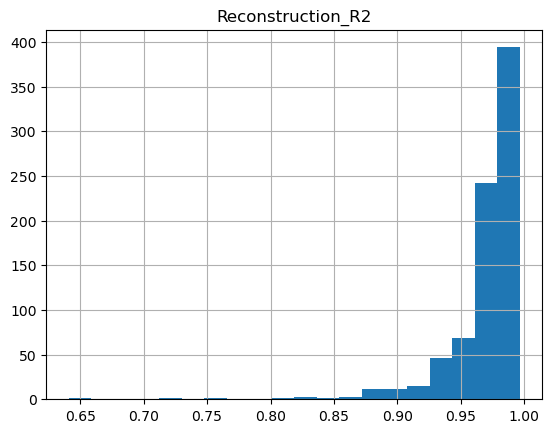

In [17]:
condition_dataset = organic_metrics['Dataset'] == 'object_moving'
condition_snr = organic_metrics['Noise_Condition'] == np.inf

selected_metrics = organic_metrics[condition_dataset & condition_snr]

selected_metrics.hist('Reconstruction_R2', bins=20)



In [12]:
heurstic_path = f'{datasets_dir}/for_plot_Heuristic_synthetic_pre_bootstrap.csv'
tdnn_path = f'{datasets_dir}/for_plot_config-0424-tune_ModGauss_with_scale_TDNN_synthetic_pre_bootstrap.csv'
scattershot_path = f'{datasets_dir}/0-1.5_Scattershot_synthetic_pre_bootstrap.csv'


heurstic_metrics = pd.read_csv(heurstic_path)
tdnn_metrics = pd.read_csv(tdnn_path)
scattershot_metrics = pd.read_csv(scattershot_path)



SSUMO reconstruction_r2
[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 85.0] snr
10.0    0.974326
11.0    0.977898
12.0    0.981709
13.0    0.984763
14.0    0.986333
15.0    0.988061
16.0    0.989639
17.0    0.990816
18.0    0.991413
19.0    0.992198
20.0    0.992984
21.0    0.993386
22.0    0.993688
23.0    0.994106
24.0    0.994444
25.0    0.994551
26.0    0.994726
27.0    0.994755
28.0    0.994858
29.0    0.994994
30.0    0.994797
31.0    0.994844
32.0    0.994812
33.0    0.994916
34.0    0.994871
35.0    0.995106
36.0    0.995136
37.0    0.995114
38.0    0.995241
39.0    0.995250
40.0    0.995348
41.0    0.995367
42.0    0.995419
43.0    0.995556
44.0    0.995557
45.0    0.995664
46.0    0.995684
47.0    0.995668
48.0    0.995636
49.0    0.995580
50.0    0.995432
inf     0.995514
Name:

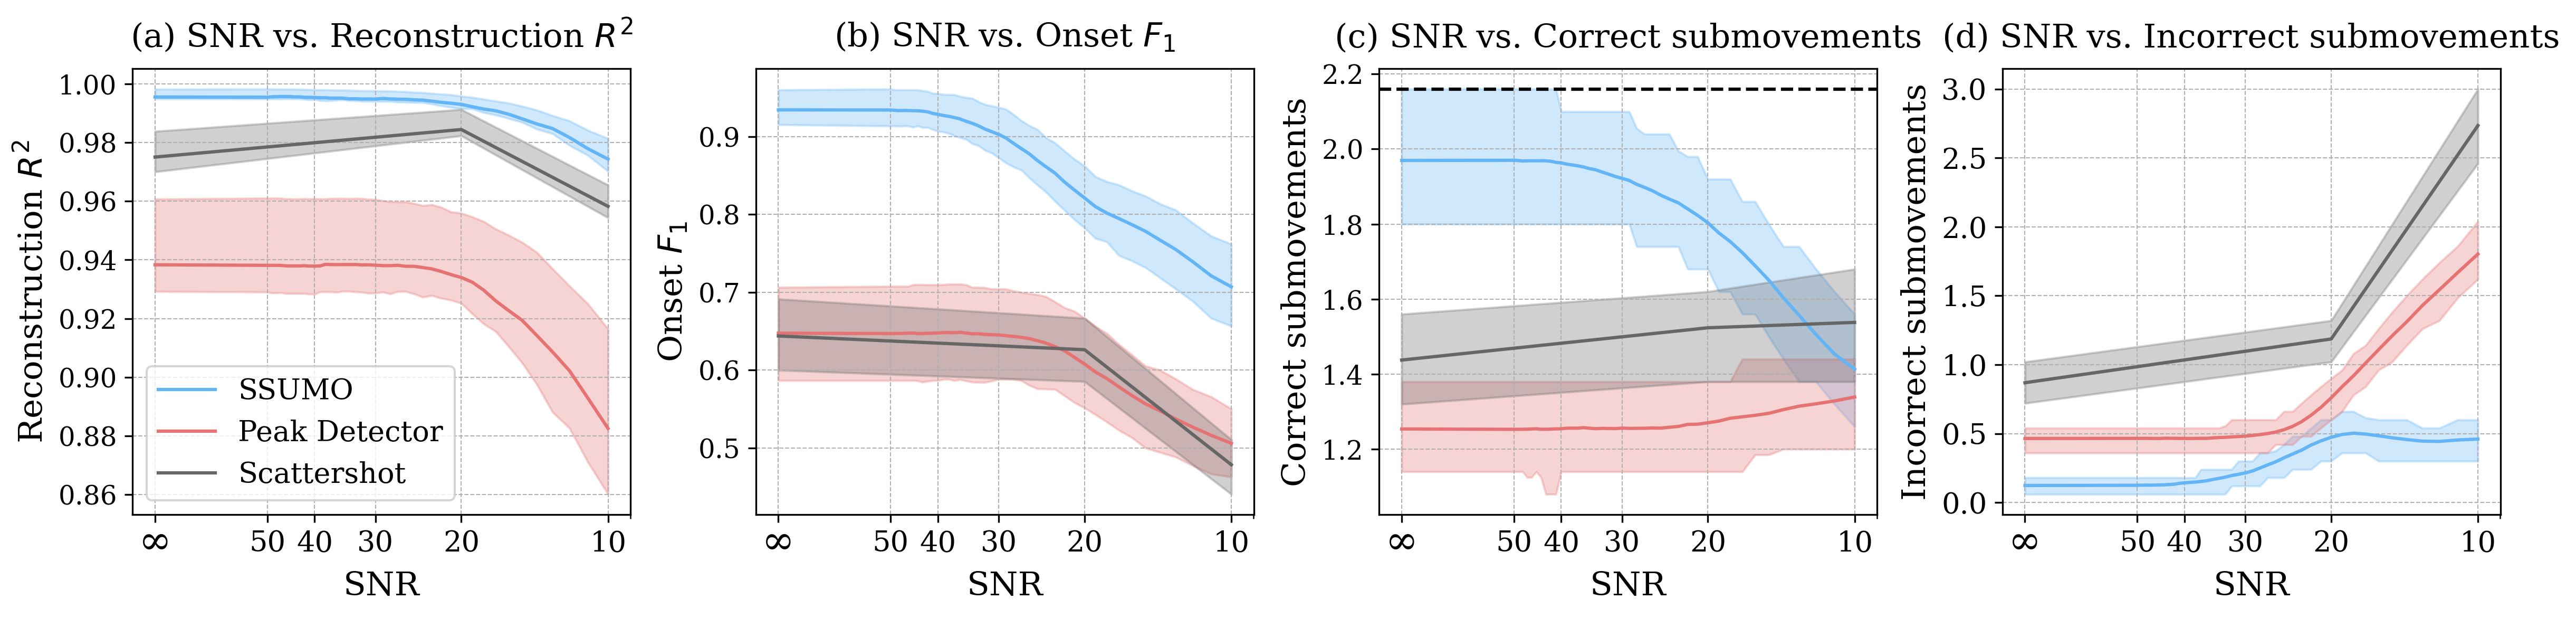

In [9]:
# --- start log‐scale plotting cell ---
import numpy as np
import matplotlib.pyplot as plt


heurstic_path = f'{datasets_dir}/for_plot_Heuristic_synthetic_pre_bootstrap.csv'
tdnn_path = f'{datasets_dir}/for_plot_config-0424-tune_ModGauss_with_scale_TDNN_synthetic_pre_bootstrap.csv'
scattershot_path = f'{datasets_dir}/0-1.5_Scattershot_synthetic_pre_bootstrap.csv'


heurstic_metrics = pd.read_csv(heurstic_path)
tdnn_metrics = pd.read_csv(tdnn_path)
scattershot_metrics = pd.read_csv(scattershot_path)

font_name = "DejaVu Serif"

plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# --- (1) build union of all snr‐indices, find numeric_snr & inf_pos as before) ---


# tdnn_metrics.groupby('snr').mean()
# tdnn_metrics.groupby('snr').median()


snr_min, snr_max = [10, np.inf]
tdnn_metrics = tdnn_metrics[(tdnn_metrics['snr'] >= snr_min) * (tdnn_metrics['snr'] <= snr_max)]
heurstic_metrics = heurstic_metrics[(heurstic_metrics['snr'] >= snr_min) * (heurstic_metrics['snr'] <= snr_max)]
scattershot_metrics = scattershot_metrics[(scattershot_metrics['snr'] >= snr_min) * (scattershot_metrics['snr'] <= snr_max)]
# heuristic_metrics = heuristic_metrics[(heuristic_metrics[snr] > snr_min) * (heuristic_metrics[snr] > snr_max)]
# tdnn_metrics = tdnn_metrics[(tdnn_metrics[snr] > snr_min) * (tdnn_metrics[snr] > snr_max)]


tdnn_means = tdnn_metrics.groupby('snr').mean(numeric_only=True)
tdnn_low_quartile = tdnn_metrics.groupby('snr').quantile(0.25, numeric_only=True)
tdnn_high_quartile = tdnn_metrics.groupby('snr').quantile(0.75, numeric_only=True)


heurstic_means = heurstic_metrics.groupby('snr').mean(numeric_only=True)
heurstic_low_quartile = heurstic_metrics.groupby('snr').quantile(0.25, numeric_only=True)
heurstic_high_quartile = heurstic_metrics.groupby('snr').quantile(0.75, numeric_only=True)

scattershot_means = scattershot_metrics.groupby('snr').mean(numeric_only=True)
scattershot_low_quartile = scattershot_metrics.groupby('snr').quantile(0.25, numeric_only=True)
scattershot_high_quartile = scattershot_metrics.groupby('snr').quantile(0.75, numeric_only=True)


true_submovements = heurstic_metrics['number_submovements_true'].iloc[0]


red_color = '#e57373'
blue_color = '#64b5f6'
black_color = '#666666'


tdnn_idx    = tdnn_means.index.to_numpy()
heur_idx    = heurstic_means.index.to_numpy()
scatt_idx   = scattershot_means.index.to_numpy()
union_snr   = np.unique(np.concatenate([tdnn_idx, heur_idx, scatt_idx]))

numeric_snr = union_snr[np.isfinite(union_snr)]
offset      = 35 # (numeric_snr.max() - numeric_snr.min()) * 1.4
inf_pos     = numeric_snr.max() + offset

plot_x_map  = {s: s for s in numeric_snr}
plot_x_map[np.inf] = inf_pos

def get_xpos(idx_array):
    return [plot_x_map[s] for s in idx_array]

x_tdnn  = get_xpos(tdnn_idx)
x_heur  = get_xpos(heur_idx)
x_scatt = get_xpos(scatt_idx)

# --- (2) make figure ---
fig, axes = plt.subplots(1, 4, figsize=(16,4), sharey=False, dpi=300)
metrics = ['reconstruction_r2','onset_f1',
           'number_submovements_correct',
           'number_submovements_incorrect']
ylabels = ['Reconstruction $R^2$','Onset $F_1$',
           'Correct submovements','Incorrect submovements']
colors  = [blue_color, red_color, black_color]
labels  = ['SSUMO','Peak Detector','Scattershot']
titles = ['(a) SNR vs. Reconstruction $R^2$','(b) SNR vs. Onset $F_1$',
           '(c) SNR vs. Correct submovements','(d) SNR vs. Incorrect submovements']

for ax, metric, ylabel, title in zip(axes, metrics, ylabels, titles):
    # plot each curve + shaded CI
    for x_vals, means, low, high, c, lab in [
        (x_tdnn,  tdnn_means,  tdnn_low_quartile,  tdnn_high_quartile,  colors[0], labels[0]),
        (x_heur,  heurstic_means, heurstic_low_quartile, heurstic_high_quartile, colors[1], labels[1]),
        (x_scatt, scattershot_means, scattershot_low_quartile, scattershot_high_quartile, colors[2], labels[2])
    ]:
        print(lab, metric)
        print(x_vals, means[metric], low[metric], high[metric])
        ax.plot(x_vals, means[metric], color=c, lw=1.5, label=lab)
        ax.fill_between(x_vals,
                        low[metric],
                        high[metric],
                        color=c, alpha=0.3)

    # horizontal line for true submovements
    if metric == 'number_submovements_correct':
        ax.axhline(y=true_submovements, color='k', linestyle='--')

    # log‐scale x‐axis
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel('SNR', fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.grid(which='major', 
            linestyle='--', linewidth=0.5)
    # choose 5 log‐spaced ticks between min>0 and max numeric_snr
    pos_only = numeric_snr[numeric_snr > 0]
    min_pos  = pos_only.min()
    max_pos  = pos_only.max()
    log_ticks = np.array([10, 20, 30, 40, 50])
    ticks  = list(log_ticks) + [inf_pos]
    labs   = [f"{int(t)}" for t in log_ticks] + ['∞']
    ax.set_xticks(ticks)
    ax.set_xticklabels(labs, fontsize=13)

    plt.yticks(fontsize=13)

    # set fontsize of yticklabels
    # ax.set_yticklabels(labs, fontsize=13)

    # now only enlarge the ∞ label
    for lbl in ax.get_xticklabels():
        if lbl.get_text() == '∞':
            lbl.set_fontsize(18)   # pick whatever size you like
            x0, y0 = lbl.get_position()
            lbl.set_position((x0, y0 + 0.015))

    for tick in ax.xaxis.get_minor_ticks():
        if tick._loc > 50:
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

    # for line in ax.get_xgridlines():           # all vertical grid‐lines
    #     xs = line.get_xdata()
    #     # they come in pairs [x, x], so pick one
    #     xval = xs[0]
    #     # assume minor gridlines are dashed:
    #     # if xval > 50 and line.get_linestyle() == '--':
    #     line.set_visible(False)

        # ax.set_xlim(10, None)

    ax.set_title(title, pad=10, fontsize=15)

    # ax.text(-0.1, 1.1, 'a)', transform=ax.transAxes,
    #     fontsize=14, fontweight='bold', va='top', ha='right')
    # reverse so high→low
    ax.invert_xaxis()

# legend + layout
axes[0].legend(loc='lower left', fontsize=13)
plt.tight_layout()
plt.savefig('metrics vs SNR.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('metrics vs SNR.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('metrics vs SNR.svg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
# --- end log‐scale plotting cell ---

In [61]:
def calculate_bootstrap_ci(data, n_bootstrap=1000, confidence_level=0.95):
    """
    Calculate bootstrap confidence intervals for dataframe statistics.
    
    Args:
        data: DataFrame or Series to bootstrap
        n_bootstrap: Number of bootstrap samples
        confidence_level: Confidence level for the interval (default: 0.95)
    
    Returns:
        DataFrame with columns for mean, lower_ci, and upper_ci
    """
    if isinstance(data, pd.Series):
        bootstrap_samples = np.array([
            data.sample(n=len(data), replace=True).mean()
            for _ in range(n_bootstrap)
        ])
        
        mean_val = data.mean()
        lower_ci = np.percentile(bootstrap_samples, (1 - confidence_level) / 2 * 100)
        upper_ci = np.percentile(bootstrap_samples, (1 + confidence_level) / 2 * 100)
        
        return {
            'mean': mean_val,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci
        }
    
    elif isinstance(data, pd.DataFrame):
        result = {}
        for column in data.columns:
            if pd.api.types.is_numeric_dtype(data[column]):
                result[column] = calculate_bootstrap_ci(data[column], n_bootstrap, confidence_level)
        
        # Convert to DataFrame with metrics as columns and statistics as rows
        df_result = pd.DataFrame({
            metric: {
                'mean': stats['mean'],
                'lower_ci': stats['lower_ci'],
                'upper_ci': stats['upper_ci']
            }
            for metric, stats in result.items()
        })
        
        return df_result
    
    else:
        raise TypeError("Input must be a pandas Series or DataFrame")

# Example usage with groupby
# This will create a DataFrame with MultiIndex (group_value, stat) and metrics as columns
# bootstrap_stats = tdnn_metrics.groupby('snr').apply(calculate_bootstrap_ci)

# tdnn_bootstrap_stats = tdnn_metrics.groupby('snr').apply(calculate_bootstrap_ci)

In [ ]:
main_model_bootstrap_stats = main_model_metrics.groupby('snr').apply(calculate_bootstrap_ci)

0.8450704225352113 0.03598284622992187 0.03554661301140172
0.9853825995974336 0.004659245065506079 0.005874430629948857
0.8502873563218392 0.03542692939244663 0.0347415473549777
0.7488438784014211 0.11519794113415893 0.16815394651605287
0.7741935483870966 0.03740065451145402 0.03345280764635594
0.9037148345179824 0.02130218341158252 0.025476984287694737
0.7954545454545454 0.037878787878787845 0.028012684989429104
0.9565711819557314 0.011477151621878345 0.01414106135720783
0.2713178294573644 0.019625182754304527 0.019465977605512552
0.8533369867180107 0.021453582841974295 0.02306326758880206


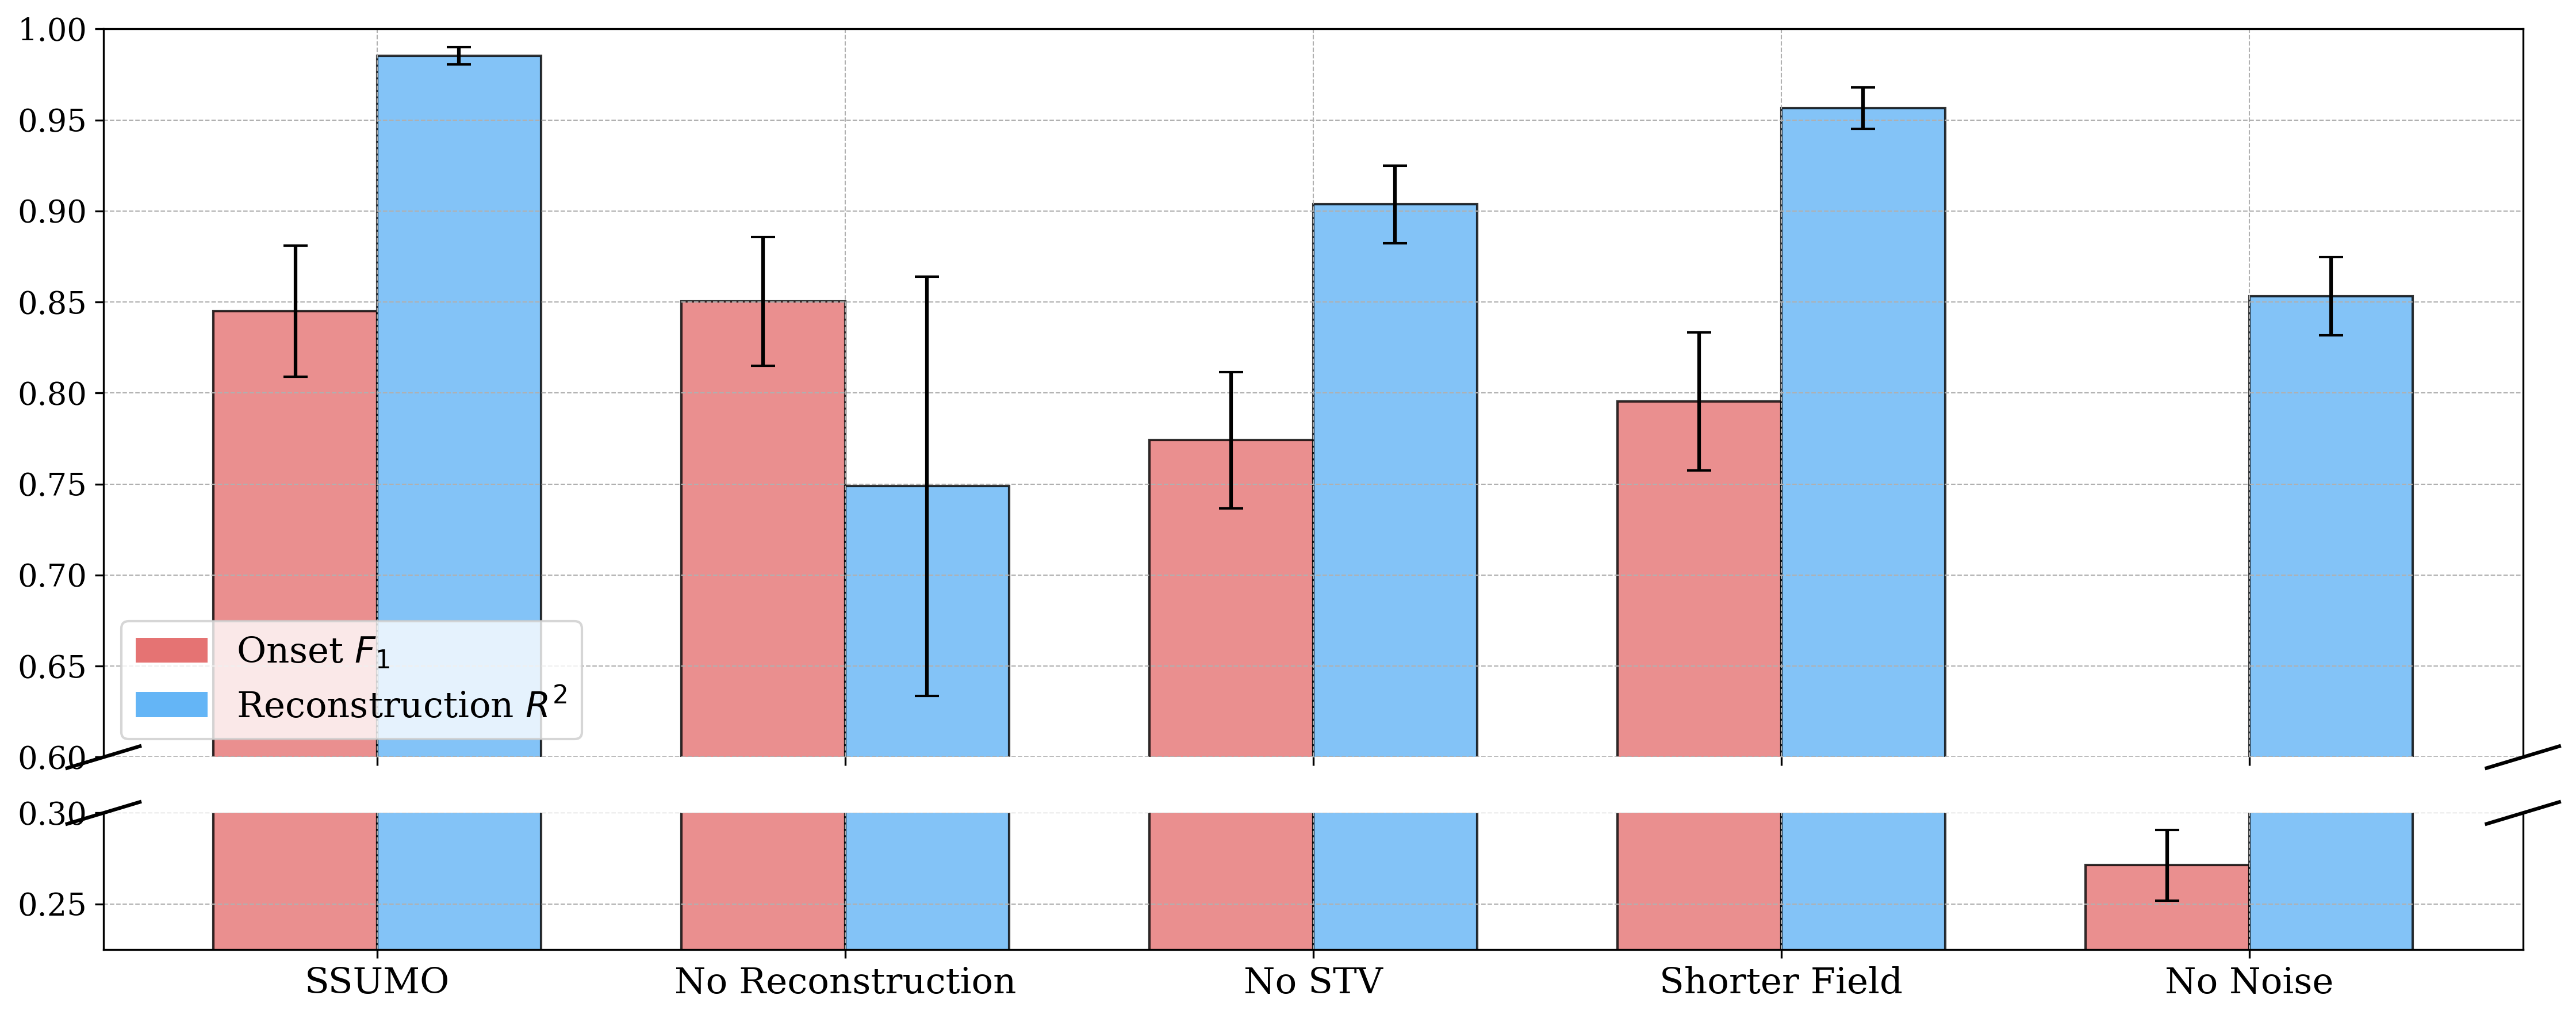

In [10]:
# Re-import required packages after kernel reset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

slected_snr = 20
selected_refractory = '0-1.5'

use_ci = False


main_model_path = f'{datasets_dir}/for_plot_config-0426-ALT_PRETRAINED_TDNN_synthetic_pre_bootstrap.csv' 
main_model_metrics = pd.read_csv(main_model_path)
main_model_metrics = main_model_metrics[main_model_metrics['snr'] == slected_snr]
# I may want to change this to the pretrained model

abs_velo_path = f'{datasets_dir}/for_plot_config-0426-ModGaussian_abs_velo_TDNN_synthetic_pre_bootstrap.csv'
abs_velo_metrics = pd.read_csv(abs_velo_path)
abs_velo_metrics = abs_velo_metrics[abs_velo_metrics['snr'] == slected_snr]

no_reconstruction_path = f'{datasets_dir}/for_plot_config-0426-ModGaussian_no_reconstruction_TDNN_synthetic_pre_bootstrap.csv'
no_reconstruction_metrics = pd.read_csv(no_reconstruction_path)
no_reconstruction_metrics = no_reconstruction_metrics[no_reconstruction_metrics['snr'] == slected_snr]

no_noise_path = f'{datasets_dir}/for_plot_config-0426-ModGaussian_no_noise_TDNN_synthetic_pre_bootstrap.csv'
no_noise_metrics = pd.read_csv(no_noise_path)
no_noise_metrics = no_noise_metrics[no_noise_metrics['snr'] == slected_snr]

shorter_kernel_path = f'{datasets_dir}/for_plot_config-0426-ModGaussian_shorter_kernel_TDNN_synthetic_pre_bootstrap.csv'
shorter_kernel_metrics = pd.read_csv(shorter_kernel_path)
shorter_kernel_metrics = shorter_kernel_metrics[shorter_kernel_metrics['snr'] == slected_snr]


metric_dfs_list = [main_model_metrics, no_reconstruction_metrics, abs_velo_metrics, shorter_kernel_metrics, no_noise_metrics]

# onset_f1_list = []
# onset_f1_upper_error_list = []
# onset_f1_lower_error_list = []

# reconstruction_r2_list = []
# reconstruction_r2_upper_error_list = []
# reconstruction_r2_lower_error_list = []


onset_f1_list = [95.7, 95.2, 93.235, 92.339, 24.212]
onset_f1_upper_error_list = [0.5, 0.5, 0.5, 0.5, 0.5]
onset_f1_lower_error_list = [0.5, 0.5, 0.5, 0.5, 0.5]

reconstruction_r2_list = [99.8, 95.3, 95.0, 99.648, 97.293]
reconstruction_r2_upper_error_list = [0.5, 0.5, 0.5, 0.5, 0.5]
reconstruction_r2_lower_error_list = [0.5, 0.5, 0.5, 0.5, 0.5]

onset_f1_list = [0.957, 0.952, 0.93235, 0.92339, 0.24212]
onset_f1_upper_error_list = [0.015, 0.015, 0.015, 0.015, 0.015]
onset_f1_lower_error_list = [0.015, 0.015, 0.015, 0.015, 0.015]

reconstruction_r2_list = [0.998, 0.953, 0.950, 0.99648, 0.97293]
reconstruction_r2_upper_error_list = [0.015, 0.015, 0.015, 0.015, 0.015]
reconstruction_r2_lower_error_list = [0.015, 0.015, 0.015, 0.015, 0.015]

for i, metric_df in enumerate(metric_dfs_list):
    if use_ci:
        bootstrap_metrics = metric_df.groupby('snr').apply(calculate_bootstrap_ci)
        onset_f1_list[i] = bootstrap_metrics.loc[slected_snr, 'mean']['onset_f1']
        onset_f1_upper_error_list[i] = bootstrap_metrics.loc[slected_snr, 'upper_ci']['onset_f1'] - onset_f1_list[i]
        onset_f1_lower_error_list[i] = onset_f1_list[i] - bootstrap_metrics.loc[slected_snr, 'lower_ci']['onset_f1']

        reconstruction_r2_list[i] = bootstrap_metrics.loc[slected_snr, 'mean']['reconstruction_r2']
        reconstruction_r2_upper_error_list[i] = bootstrap_metrics.loc[slected_snr, 'upper_ci']['reconstruction_r2'] - reconstruction_r2_list[i]
        reconstruction_r2_lower_error_list[i] = reconstruction_r2_list[i] - bootstrap_metrics.loc[slected_snr, 'lower_ci']['reconstruction_r2']
    else:
        onset_f1_list[i] = metric_df['onset_f1'].median()
        onset_f1_upper_error_list[i] = metric_df['onset_f1'].quantile(0.75) - onset_f1_list[i]
        onset_f1_lower_error_list[i] = onset_f1_list[i] - metric_df['onset_f1'].quantile(0.25)
        print(onset_f1_list[i], onset_f1_upper_error_list[i], onset_f1_lower_error_list[i])

        reconstruction_r2_list[i] = metric_df['reconstruction_r2'].median()
        reconstruction_r2_upper_error_list[i] = metric_df['reconstruction_r2'].quantile(0.75) - reconstruction_r2_list[i]
        reconstruction_r2_lower_error_list[i] = reconstruction_r2_list[i] - metric_df['reconstruction_r2'].quantile(0.25)
        print(reconstruction_r2_list[i], reconstruction_r2_upper_error_list[i], reconstruction_r2_lower_error_list[i])



# Updated data after removing "Absolute Velocity" and shifting its values to "No STV"
titles = ['SSUMO', 'No Reconstruction', 'No STV', 'Shorter Field', 'No Noise']

x = np.arange(len(titles))
width = 0.35

# Font and colors
fallback_font = "DejaVu Serif"
red_color = '#e57373'
blue_color = '#64b5f6'

# Recreate split-axis plot with correct ratio (top 3x taller than bottom)

plot_ratio = 8./1.5

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6), dpi=300,
                               gridspec_kw={'height_ratios': [plot_ratio, 1]})




# Plot bars
bars1_ax1 = ax1.bar(x - width/2, onset_f1_list, width, color=red_color, edgecolor='black', yerr=onset_f1_upper_error_list, capsize=5, alpha=0.8)
bars2_ax1 = ax1.bar(x + width/2, reconstruction_r2_list, width, color=blue_color, edgecolor='black', yerr=reconstruction_r2_upper_error_list, capsize=5, alpha=0.8)

bars1_ax2 = ax2.bar(x - width/2, onset_f1_list, width, color=red_color, edgecolor='black', yerr=onset_f1_lower_error_list, capsize=5, alpha=0.8)
bars2_ax2 = ax2.bar(x + width/2, reconstruction_r2_list, width, color=blue_color, edgecolor='black', yerr=reconstruction_r2_lower_error_list, capsize=5, alpha=0.8)

# Axis limits and ticks
ax1.set_ylim(0.6, 1)
ax2.set_ylim(0.225, 0.3)
ax1_ticks = np.arange(0.6, 1.01, 0.05)
ax2_ticks = np.arange(0.25, 0.31, 0.05) 
ax1.set_yticks(ax1_ticks, labels=[f"{tick:.2f}" for tick in ax1_ticks], fontsize=13)
ax2.set_yticks(ax2_ticks, labels=[f"{tick:.2f}" for tick in ax2_ticks], fontsize=13)



# Add axis break indicators
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d * plot_ratio, 1 + d * plot_ratio), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d * plot_ratio, 1 + d * plot_ratio), **kwargs)

# Titles and labels
# ax1.set_ylabel('Percentages', fontname=fallback_font, y=0.4)
# ax2.set_ylabel('Percentages', fontname=fallback_font)
# ax1.set_title('Ablation studies', fontname=fallback_font)
ax2.set_xticks(x)
ax2.set_xticklabels(titles, 
                    # rotation=15, 
                    fontname=fallback_font,
                    fontsize=15)

custom_legend = [
    Patch(facecolor=red_color, label='Onset $F_1$'),
    Patch(facecolor=blue_color, label='Reconstruction $R^2$'),
]

ax1.legend(handles=custom_legend, fontsize=15, loc='lower left')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax2.grid(True, linestyle='--', linewidth=0.5)

# Font application
for label in ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontname(fallback_font)
for label in ax2.get_xticklabels():
    label.set_fontname(fallback_font)


plt.tight_layout()
plt.savefig('ablation_studies.pdf')
plt.savefig('ablation_studies.png')
plt.savefig('ablation_studies.svg')
plt.show()


In [ ]:
# Measuring time

time_measurement = False

if time_measurement:

    dataset.seed = 2**16
    dataset.min_allowed_refractory = 2
    dataset.refractory_distribution.low = torch.tensor(0.)
    dataset.refractory_distribution.high = torch.tensor(.5)
    dataset.batch_size = 1
    dataset.snr_distribution = dataset.convert_distribution(10)

    x = dataset.__getitem__(0)[0]
    x = x.reshape(1, 1, -1) # 119.5 sec
    print(f'{x.numel()/60} seconds')

    model(x)


    try:
        model.eval()
    except:
        pass

    num_runs = 100
    times = []
    with torch.no_grad():
        for i in range(num_runs):
            tm_start = time.time()
            _ = model(x)
            tm_end = time.time()
            times.append(tm_end - tm_start)
            print(times[-1]/x.numel() * 60)
        print(f'Time: {(np.mean(times))/x.numel() * 60}')

    times